In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from __future__ import print_function, absolute_import, division

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data", one_hot = True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
num_steps = 10000
batch_size = 128
lr_generator = 0.002
lr_discriminator = 0.002

image_dim = 784
noise_dim = 100

In [4]:
noise_input = tf.placeholder(tf.float32, shape = [None, noise_dim])
real_image_input = tf.placeholder(tf.float32, shape = [None, 28, 28, 1])

is_training = tf.placeholder(tf.bool)

def leakyrelu(x, alpha = 0.2):
    return 0.5 * (1 + alpha) * x + 0.5 * (1 - alpha) * abs(x)

def generator(x, reuse = False):
    with tf.variable_scope('Generator', reuse = reuse):
        x = tf.layers.dense(x, units = 7 * 7 * 128)
        x = tf.layers.batch_normalization(x, training = is_training)
        x = tf.nn.relu(x)
        x = tf.reshape(x, shape = [-1, 7, 7, 128])
        x = tf.layers.conv2d_transpose(x, 64, 5, strides = 2, padding = 'same')
        x = tf.layers.batch_normalization(x, training = is_training)
        x = tf.nn.relu(x)
        x = tf.layers.conv2d_transpose(x, 1, 5, strides = 2, padding = 'same')
        x = tf.nn.tanh(x)
        
    return x
    
def discriminator(x, reuse = False):
    with tf.variable_scope('Discriminator', reuse = reuse):
        x = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_training)
        x = leakyrelu(x)
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_training)
        x = leakyrelu(x)
        x = tf.reshape(x, shape=[-1, 7*7*128])
        x = tf.layers.dense(x, 1024)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = leakyrelu(x)
        x = tf.layers.dense(x, 2)
        
    return x


gen_sample = generator(noise_input)

disc_real = discriminator(real_image_input)
disc_fake = discriminator(gen_sample, reuse = True)

stacked_gan = discriminator(gen_sample, reuse = True)


disc_loss_real = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits = disc_real, labels = tf.ones([batch_size], dtype = tf.int32)))

disc_loss_fake = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=disc_fake, labels=tf.zeros([batch_size], dtype=tf.int32)))

disc_loss = disc_loss_real + disc_loss_fake

gen_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=stacked_gan, labels=tf.ones([batch_size], dtype=tf.int32)))


optimizer_gen = tf.train.AdamOptimizer(learning_rate=lr_generator, beta1=0.5, beta2=0.999)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=lr_discriminator, beta1=0.5, beta2=0.999)

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')


gen_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Generator')

with tf.control_dependencies(gen_update_ops):
    train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
disc_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Discriminator')
with tf.control_dependencies(disc_update_ops):
    train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)

    
init = tf.global_variables_initializer()

In [6]:
sess = tf.Session()

sess.run(init)

for i in range(1, num_steps + 1):
    batch_x,_ = mnist.train.next_batch(128)
    batch_x = np.reshape(batch_x, newshape = [-1, 28, 28, 1])
    batch_x = batch_x * 2. - 1
    
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])
    _, dl = sess.run([train_disc, disc_loss], feed_dict={real_image_input: batch_x, noise_input: z, is_training:True})
    
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])
    _, gl = sess.run([train_gen, gen_loss], feed_dict={noise_input: z, is_training:True})
    
    if i % 500 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))

Step 1: Generator Loss: 4.383510, Discriminator Loss: 1.883173
Step 500: Generator Loss: 1.426325, Discriminator Loss: 0.900010
Step 1000: Generator Loss: 1.753902, Discriminator Loss: 0.689134
Step 1500: Generator Loss: 1.987217, Discriminator Loss: 0.736969
Step 2000: Generator Loss: 1.979724, Discriminator Loss: 0.990586
Step 2500: Generator Loss: 2.638596, Discriminator Loss: 0.552875
Step 3000: Generator Loss: 3.171246, Discriminator Loss: 0.302877
Step 3500: Generator Loss: 3.283959, Discriminator Loss: 0.288705
Step 4000: Generator Loss: 4.215531, Discriminator Loss: 0.319932
Step 4500: Generator Loss: 4.543117, Discriminator Loss: 0.246691
Step 5000: Generator Loss: 4.924434, Discriminator Loss: 0.215594
Step 5500: Generator Loss: 5.062992, Discriminator Loss: 0.273131
Step 6000: Generator Loss: 5.066754, Discriminator Loss: 0.468628
Step 6500: Generator Loss: 6.002891, Discriminator Loss: 0.121041
Step 7000: Generator Loss: 5.502769, Discriminator Loss: 0.119313
Step 7500: Gen

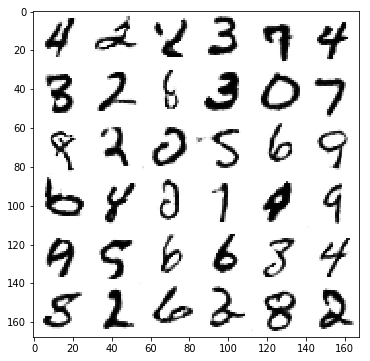

In [7]:
n = 6
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    # Noise input.
    z = np.random.uniform(-1., 1., size=[n, noise_dim])
    # Generate image from noise.
    g = sess.run(gen_sample, feed_dict={noise_input: z, is_training:False})
    # Rescale values to the original [0, 1] (from tanh -> [-1, 1])
    g = (g + 1.) / 2.
    # Reverse colours for better display
    g = -1 * (g - 1)
    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()